**FRAME ALLOCATIONS ALGORITHMS(For Multiple Processes):**

An important aspect of operating systems, virtual memory is implemented using demand paging. Demand paging necessitates the development of a page-replacement algorithm and a frame allocation algorithm. Frame allocation algorithms are used if you have multiple processes; it helps decide how many frames to allocate to each process.

When multiple processes are running, the operating system must decide how to distribute available physical memory frames among them. If a process doesn't have enough frames for the pages it needs, it suffers page faults.

**Thrashing:** A state where a process keeps page-faulting so frequently that it's spending more time swapping pages than executing code. Happens when a process has too few frames to hold its active pages.

**Working Set:** The set of pages that a process is actively using during a recent time window. If the process has enough frames to hold its working set → few page faults. If not -> thrashing


**Random Allocation:** Give each process a random number of frames, regardless of how big it is or how it behaves without exceeding the maximum capacity. This is not used in current operating systems, used for simulation purposes generally. The problem of this algorithm is that a large or active process might get very few frame which will result in lots of page faults, and a small idle process might get many frames it doesn't need which is a waste of memory.

Implementation:
  1. When a process needs memory frames, the OS randomly selects frames from the pool of available frames

  2. The selection is typically done using a random number generator

  3. There's no attempt to distribute frames based on process size, priority, or any other factor


**Proportional Allocation:** Frames are allocated to each process according to the process size. For each process, calculate: (process_size / total_size) * total_frames. For instance, in a system with 62 frames, if there is a process of 10KB and another process of 127KB, then the first process will be allocated (10/137)*62 = 4 frames and the other process will get (127/137)*62 = 57 frames.

  * Proportional Calculation: Allocates frames based on each process's size relative to total size

  * Two-Pass Allocation:

      1. First pass assigns integer portion of frames

      2. Second pass distributes remaining frames using largest remainder method

  * Dynamic Reallocation: Automatically reallocates when processes are removed

  * Status Tracking: Maintains process sizes and allocated frame counts

Advantage: All the processes share the available frames according to their needs rather than equality.



**Page Fault Frequency Algorithm:**
The Page Fault Frequency (PFF) algorithm is a dynamic memory management technique that adjusts the number of frames allocated to a process based on its page fault rate. The goal is to maintain an optimal balance between too many page faults (thrashing) and wasting memory (over-allocation).

Page fault rate: Measures how often a process encounters page faults per unit time. If it is too high, process needs more frames. If it is too low, the process may have excess frames that can be reclaimed.

Upper and Lower Thresholds:
  * Upper Threshold (T_high): If PFR > T_high, allocate more frames.

  * Lower Threshold (T_low): If PFR < T_low, deallocate frames.

Working Principle: Monitors page faults over a time window and adjusts the frame allocation dynamically to keep PFR between T_LOW and T_HIGH.

Implementation Steps:
1. Define Data Structures

  * Page Table: Tracks which pages are in memory.

  * FIFO/LRU Queue: Helps in page replacement.

  * Page Fault Counter: Counts faults per process.

2. Monitor Page Faults

    * For each process, track page faults in a time interval.

    * Compute Page Fault Rate (PFR) = (Faults in interval) / (Interval length).

3. Compare with Thresholds

    * If PFR > T_high:

      * The process is thrashing → allocate more frames.

      * Steal frames from processes with low PFR.

    * If PFR < T_low:

      * The process has excess frames → deallocate some frames.

      * Give frames to processes needing more


**Working Set Algorithm:**
The Working Set Model is a memory management technique that tracks the set of pages a process actively uses (its "working set") to optimize page fault rates and prevent thrashing.

Working set: The set of pages referenced by a process in the last Δ (delta) time units. Represents the active memory needed for efficient execution.

Window Size (Δ): A tunable parameter defining how far back to look for page references. If it is too small->misses important pages. If it is too large->includes stale pages.

Strategy: If a page not in the working set is accessed, it generates a page fault. Only the pages outside of the working set are candidates for eviction.

Implementation steps:
1. Track Page References

  * Maintain a sliding window of page accesses for each process.

  * Example: If Δ = 5, track the last 5 page references.

2. Compute Working Set

  * For each process, collect all unique pages accessed in the last Δ references.

3. Page Fault Handling

  * If the accessed page is in the working set:

      * It's a page hit (no action needed).

  * If the page is not in the working set:

      * It's a page fault → load the page into memory.

        If no free frames, evict a page not in any process's working set.

4. Dynamic Adjustment

  * Periodically update the working set as new references occur.

  * Adjust Δ empirically (e.g., based on observed page fault rates).



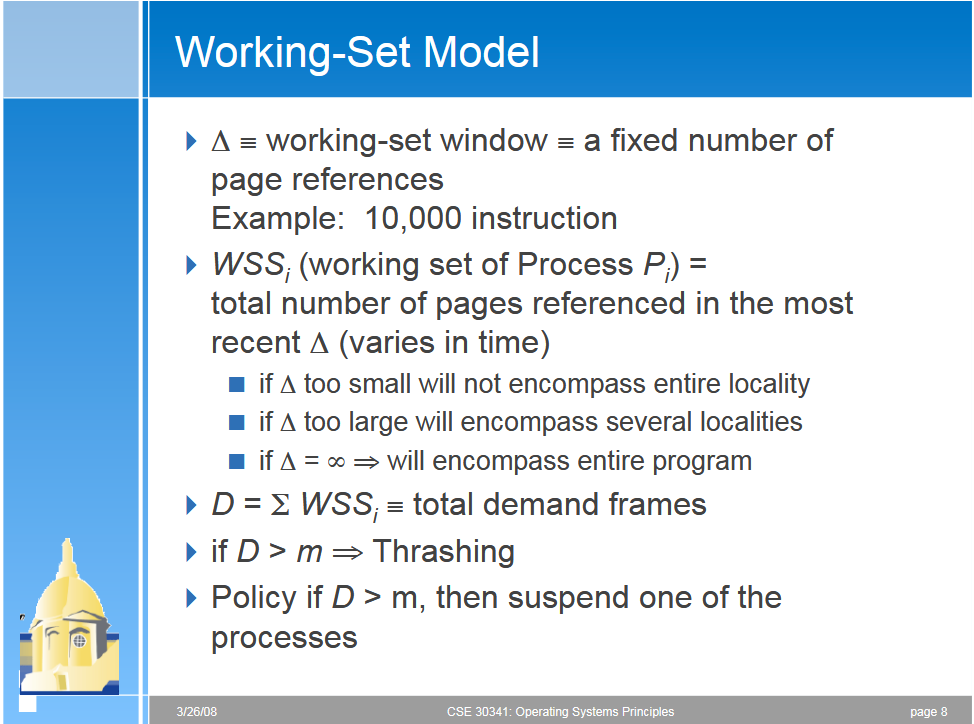

src: https://surendar.chandrabrown.org/teach/spr08/cse30341/videos/Lecture24.pdf

**COMPARISON**

Working set algorithm will generate the less page faults and Random algorithm will generate the most page faults. Proportional and PFF will be in between.

Page Faults:
Random > Proportional > PFF > Working Set


Random Allocation Implementation:

In [ ]:
import random
from collections import deque

def random_allocation(processes, total_frames):
    num_processes = len(processes)

    allocations = [random.randint(1, total_frames) for _ in range(num_processes)]
    total_alloc = sum(allocations)
    scale = total_alloc / total_frames
    allocations = [max(1, int(a / scale)) for a in allocations]

    while sum(allocations) > total_frames:
        i = random.randint(0, num_processes - 1)
        if allocations[i] > 1:
            allocations[i] -= 1

    total_faults = 0

    for i in range(num_processes):
        ref_str = processes[i]
        frame_count = allocations[i]
        frames = set()
        queue = deque()
        faults = 0

        for page in ref_str:
            if page not in frames:
                faults += 1
                if len(frames) >= frame_count:
                    old_page = queue.popleft()
                    frames.remove(old_page)
                frames.add(page)
                queue.append(page)

        print(f"Process {i+1}: Frames = {frame_count}, Page Faults = {faults}")
        total_faults += faults

    print(f"\nTotal Page Faults: {total_faults}")
    return total_faults


Proportional Allocation Implementation:

In [37]:
from collections import deque

def proportional_allocation(total_frames, process_sizes, reference_strings):
    total_size = sum(size for _, size in process_sizes)
    num_processes = len(process_sizes)

    allocations = []
    for pid, size in process_sizes:
        frames = int((size / total_size) * total_frames)
        allocations.append(max(1, frames))


    while sum(allocations) < total_frames:
        max_index = max(range(num_processes), key=lambda i: process_sizes[i][1])
        allocations[max_index] += 1

    total_faults = 0


    for i in range(num_processes):
        frames = set()
        queue = deque()
        faults = 0
        frame_limit = allocations[i]
        ref = reference_strings[i]

        for page in ref:
            if page not in frames:
                faults += 1
                if len(frames) >= frame_limit:
                    removed = queue.popleft()
                    frames.remove(removed)
                frames.add(page)
                queue.append(page)

        pid = process_sizes[i][0]
        print(f"Process {pid}: Frames = {frame_limit}, Page Faults = {faults}")
        total_faults += faults

    print(f"\nTotal Page Faults: {total_faults}")
    return total_faults




Page Fault Frequency:


In [ ]:
from collections import deque

def pff_allocation(total_frames, access_sequence, t_high=0.3, t_low=0.1, window=5):
    frames = {}
    queues = {}
    faults = {}
    frame_count = {}
    available = total_frames
    total_faults = 0

    for pid, page in access_sequence:
        if pid not in frames:
            frames[pid] = set()
            queues[pid] = deque()
            faults[pid] = []
            frame_count[pid] = 0

        if page in frames[pid]:
            faults[pid].append(0)
        else:
            total_faults += 1
            faults[pid].append(1)

            if len(faults[pid]) > window:
                faults[pid].pop(0)

            fault_rate = sum(faults[pid]) / len(faults[pid])

            if frame_count[pid] < len(frames[pid]) or page not in frames[pid]:
                if frame_count[pid] < total_frames and available > 0:
                    frames[pid].add(page)
                    queues[pid].append(page)
                    frame_count[pid] += 1
                    available -= 1
                    continue

            if fault_rate > t_high:
                stolen = False
                for other_pid in frames:
                    if other_pid == pid or not queues[other_pid]:
                        continue
                    other_fault_rate = sum(faults[other_pid]) / len(faults[other_pid]) if faults[other_pid] else 0
                    if other_fault_rate < t_low:
                        evicted = queues[other_pid].popleft()
                        frames[other_pid].remove(evicted)
                        frame_count[other_pid] -= 1

                        frames[pid].add(page)
                        queues[pid].append(page)
                        frame_count[pid] += 1
                        stolen = True
                        break
                if stolen:
                    continue

            if len(frames[pid]) >= frame_count[pid]:
              if queues[pid]:
                evicted = queues[pid].popleft()
                frames[pid].remove(evicted)
            frames[pid].add(page)
            queues[pid].append(page)

    print(f"Total Page Faults: {total_faults}")
    return total_faults


Working Set Allocation Implementation:

In [39]:

def working_set_allocation(total_frames, access_sequence, window_size=3):
    allocated = {}
    recent_uses = {}
    available = total_frames
    page_faults = 0

    for pid, page in access_sequence:
        if pid not in allocated:
            allocated[pid] = set()
            recent_uses[pid] = []


        recent_uses[pid].append(page)
        if len(recent_uses[pid]) > window_size:
            recent_uses[pid].pop(0)


        if page in allocated[pid]:
            continue


        page_faults += 1


        if available > 0:
            allocated[pid].add(page)
            available -= 1
            continue


        working_pages = set()
        for pages in recent_uses.values():
            working_pages.update(pages)


        evicted = False
        for other_pid in list(allocated.keys()):
            for p in list(allocated[other_pid]):
                if p not in working_pages:
                    allocated[other_pid].remove(p)
                    allocated[pid].add(page)
                    evicted = True
                    break
            if evicted:
                break


        if not evicted:
            evict_pid = random.choice(list(allocated.keys()))
            if allocated[evict_pid]:
                evicted_page = allocated[evict_pid].pop()
                allocated[pid].add(page)

    print("\nFinal Allocation:")
    for pid in allocated:
        print(f"Process {pid}: {allocated[pid]}")
    print(f"TOTAL PAGE FAULTS: {page_faults}")
    return page_faults


Comparison:

Process 1: Frames = 2, Page Faults = 12
Process 2: Frames = 1, Page Faults = 12
Process 3: Frames = 1, Page Faults = 9
Process 4: Frames = 1, Page Faults = 12
Process 5: Frames = 2, Page Faults = 10
Process 6: Frames = 2, Page Faults = 10

Total Page Faults: 65
Process 1: Frames = 2, Page Faults = 12
Process 2: Frames = 4, Page Faults = 5
Process 3: Frames = 1, Page Faults = 9
Process 4: Frames = 1, Page Faults = 12
Process 5: Frames = 1, Page Faults = 10
Process 6: Frames = 1, Page Faults = 12

Total Page Faults: 60
Total Page Faults: 20

Final Allocation:
Process 1: {5, 6}
Process 2: {5, 6, 7, 8, 9}
Process 3: {20, 10, 30}
TOTAL PAGE FAULTS: 19


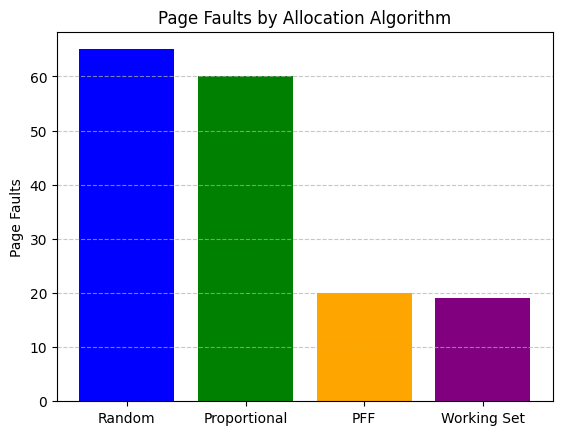

In [40]:
import matplotlib.pyplot as plt
import random

def compare_algorithms():
    total_frames = 10
    process_sizes = [(1, 12), (2, 15), (3, 10), (4, 8), (5, 7), (6, 6)]
    ref1 = [1, 2, 3, 1, 2, 3, 4, 1, 2, 4, 5, 6]   # Repeated pages with some variation
    ref2 = [5, 6, 7, 5, 6, 8, 7, 9, 6, 7, 8, 9]   # Pages with slight overlaps, shifting sequence
    ref3 = [10, 20, 10, 30, 40, 50, 10, 20, 30]    # Larger page numbers, some repetition
    ref4 = [1, 3, 5, 7, 9, 1, 3, 5, 7, 9, 2, 4]   # Non-contiguous, but repetitive access patterns
    ref5 = [8, 9, 10, 11, 8, 9, 12, 13, 14, 15]   # Longer sequence with gradual shifts
    ref6 = [1, 2, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3]
    reference_strings = [ref1, ref2, ref3, ref4, ref5, ref6]

    access_sequence = [(1, p) for p in ref1] + [(2, p) for p in ref2] + [(3, p) for p in ref3]

    results = {
        "Random": random_allocation(reference_strings, total_frames),
        "Proportional": proportional_allocation(total_frames, process_sizes, reference_strings),
        "PFF": pff_allocation(total_frames, access_sequence),
        "Working Set": working_set_allocation(total_frames, access_sequence),
    }

    # Plotting
    plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange', 'purple'])
    plt.ylabel("Page Faults")
    plt.title("Page Faults by Allocation Algorithm")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Run it
compare_algorithms()
